# Data Analysis with Python

This tutorial builds upon the previous posts on Pandas and data wrangling by demonstrating methods to conduct data analysis with Python. For this example we will use NYC's PLUTO dataset which is the city's building data from the Planning department.

Data can either be accessed from the course AWS SQL database or downloaded from this link.

In [129]:
import pandas as pd
import numpy as np
import geopandas as gpd
import psycopg2 as pg
import os
import matplotlib.pyplot as plt
import cenpy
from scipy.stats import pearsonr
pd.options.display.min_rows = 100

In [1]:
path = '/Users/carlo/Downloads/nyc_pluto_20v6_csv/pluto_20v6.csv'

In [22]:
df = pd.read_csv(path, low_memory=False, 
                 dtype={'block': str, 'lot': str,
                        'cd': str, 'ct2010': str,
                        'cb2010': str, 'schooldist': str,
                        'council': str, 'zipcode': str,
                        'landuse': str, 'bbl': str})
df['bbl'] = df['bbl'].str.replace('.00000000', '')

In [23]:
print(df.shape)
df.head()

(858308, 90)


,borough,block,lot,cd,ct2010,cb2010,schooldist,council,zipcode,firecomp,policeprct,healthcenterdistrict,healtharea,sanitboro,sanitdistrict,sanitsub,address,zonedist1,zonedist2,zonedist3,zonedist4,overlay1,overlay2,spdist1,spdist2,spdist3,ltdheight,splitzone,bldgclass,landuse,easements,ownertype,ownername,lotarea,bldgarea,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,otherarea,areasource,numbldgs,numfloors,unitsres,unitstotal,lotfront,lotdepth,bldgfront,bldgdepth,ext,proxcode,irrlotcode,lottype,bsmtcode,assessland,assesstot,exempttot,yearbuilt,yearalter1,yearalter2,histdist,landmark,builtfar,residfar,commfar,facilfar,borocode,bbl,condono,tract2010,xcoord,ycoord,zonemap,zmcode,sanborn,taxmap,edesignum,appbbl,appdate,plutomapid,firm07_flag,pfirm15_flag,version,dcpedited,latitude,longitude,notes
0,BX,5639,78,210,NaN,0002,NaN,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MARINE STREET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V0,11,0.0,NaN,EDWIN EROSA,6936.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,0.0,0.0,0.0,0.0,16.00,400.00,0.00,0.00,NaN,0.0,Y,5.0,5.0,900.0,900.0,0.0,0.0,0.0,0.0,NaN,NaN,0.00,0.00,0.0,0.0,2,2056390078,NaN,NaN,1044920.0,245489.0,4d,NaN,218 072,21810.0,NaN,NaN,NaN,4,1.0,1.0,20v6,NaN,40.840277,-73.780735,NaN
1,BK,8273,111,318,1018,1001,18,46,11236,L170,69.0,33.0,7520.0,3.0,18.0,1C,FLATLANDS 5 STREET,R5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,V9,11,0.0,C,NYC DEPARTMENT OF PARKS AND RECREATION,12600.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,0.0,0.0,0.0,0.0,105.75,70.00,0.00,0.00,NaN,0.0,Y,5.0,5.0,805050.0,805050.0,805050.0,0.0,0.0,0.0,NaN,NaN,0.00,1.25,0.0,2.0,3,3082730111,NaN,1018.0,1015855.0,173966.0,23c,NaN,317 085,32406.0,NaN,NaN,NaN,4,1.0,1.0,20v6,t,40.644117,-73.886114,NaN
2,BX,5092,18,212,436,1000,11,12,10466,E063,47.0,24.0,520.0,2.0,12.0,5C,4422 ELY AVENUE,R4A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,B2,01,0.0,NaN,"SEEWAH, LALBATCHAN",2185.0,1056.0,0.0,1056.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,37.25,99.33,16.00,32.00,G,1.0,Y,3.0,2.0,9180.0,27780.0,0.0,1925.0,0.0,0.0,NaN,NaN,0.48,0.75,0.0,2.0,2,2050920018,NaN,436.0,1026055.0,267023.0,2a,NaN,222 014,21709.0,NaN,NaN,NaN,1,NaN,NaN,20v6,NaN,40.899491,-73.848780,NaN
3,BK,2392,7503,301,551,3000,14,34,11249,E221,90.0,30.0,400.0,3.0,1.0,2B,125 SOUTH 1 STREET,R6B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,R1,02,0.0,NaN,UNAVAILABLE OWNER,2375.0,5066.0,0.0,5066.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,4.0,4.0,4.0,25.00,48.58,25.00,48.58,NaN,2.0,Y,0.0,5.0,118799.0,962550.0,370696.0,2012.0,0.0,0.0,NaN,NaN,2.13,2.00,0.0,2.0,3,3023927503,3698.0,551.0,994659.0,199555.0,12d,NaN,304 011,30805.0,NaN,3.023920e+09,07/07/2015,1,NaN,NaN,20v6,NaN,40.714403,-73.962452,NaN
4,BK,2363,7502,301,555,1016,14,33,11249,E221,90.0,30.0,400.0,3.0,1.0,2B,221 KENT AVENUE,M1-2/R6A,NaN,NaN,NaN,NaN,NaN,MX-8,NaN,NaN,NaN,N,R4,03,0.0,NaN,UNAVAILABLE OWNER,14112.0,46121.0,3825.0,42296.0,0.0,0.0,3825.0,0.0,0.0,0.0,2.0,1.0,7.0,50.0,86.0,0.00,0.00,71.82,166.26,NaN,0.0,Y,3.0,5.0,317262.0,6541196.0,6314574.0,2008.0,0.0,0.0,NaN,NaN,3.27,3.00,2.0,3.0,3,3023637502,3007.0,555.0,994007.0,200552.0,12c,NaN,304 011,30805.0,NaN,3.023630e+09,07/06/2012,1,NaN,NaN,20v6,NaN,40.717140,-73.964803,NaN


### Descriptive Stats

Surfacing basic statistics about buildings in NYC.

Starting by answering a few basic questions about floor height, building area, and land use across NYC.

<br>
<br>

#### What is the average number of floors in buildings across the city?
The first question is very simple to answer in Pandas, requiring only one line of code, thanks to the **.mean()** method for Series objects which returns the average of any numeric column.

In [27]:
avg_floors = df['numfloors'].mean()

print('The average number of floors within buildings is: %s' % avg_floors)

The average number of floors within buildings is: 2.3348885465632216


<br>
<br>

#### What is the average number of floors in residential buildings across the city?
The next question requires a little more effort as we have to filter the column to only return residential buildings. Thanks to the PLUTO [data dictionary](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?v=20v7), we know that the land use codes for residential are 01, 02, and 03.

In [28]:
resi_code = ['01', '02', '03']
mask = df['landuse'].isin(resi_code)
avg_floors = df['numfloors'].loc[mask].mean()

print('The average number of floors within residential is: %s' % avg_floors)

The average number of floors within residential is: 2.3240842889835496


<br>
<br>

#### What is the average number of floors in commercial buildings across the city?
We can do a similar filter for commercial buildings, just changing the land use to 05 and the borough to 'MN'.

In [34]:
com_code = ['05']
mask1 = df['landuse'].isin(com_code)
mask2 = df['borough'] == 'MN'
avg_floors = df['numfloors'].loc[(mask1) & (mask2)].mean()

print('The average number of floors within commercial is: %s' % avg_floors)

The average number of floors within commercial is: 9.829079317052086


<br>
<br>

#### What is the area distribution for residential buildings in Manhattan?
Again this question requires filtering on two columns, and this time we will plot a histogram with the **.hist()** method. To get a more granular binning of values we can specify the number of bins.

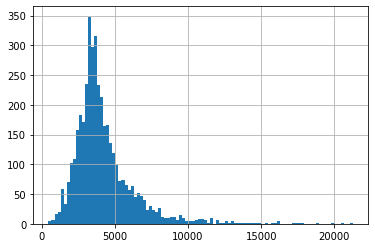

In [48]:
mask1 = df['landuse'] == '01'
mask2 = df['borough'] == 'MN'
_ = df['bldgarea'].loc[(mask1) & (mask2)].hist(bins=100)

<br>
<br>

The histogram shows a slightly skewed distribution of building areas – meaning there are a large amount of moderately sized homes with a small amount of gigantic residences over 15-20k. We can add a little more color to the distribution by plotting 1.6x the standard deviations, indicating the range we can expect 90% of values to fall within.

<br>

The **.std()** method in Pandas is a quick way to find the standard deviation of a distribution.

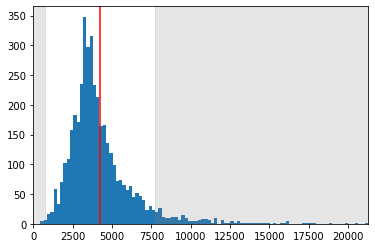

In [78]:
std = temp.std()
avg = temp.mean()

fig, ax = plt.subplots()
temp.hist(ax=ax, bins=100)
ax.axvspan(avg + (std * 1.645), temp.max(),
           alpha=0.2, color='grey')
ax.axvspan(0, avg - (std * 1.645),
               alpha=0.2, color='grey')
ax.axvline(avg, color='red')
plt.grid(False)
_ = plt.xlim(0, temp.max())

<br>
<br>

A more robust measure for studying distrubitions, particularly skewed distributions, is to look at quartiles or percentiles. Percentiles signify the proportion of values we can expect to fall within a range. For example, 3024 is the 25th percentile of residential area for homes in Manhattan. This means 25% of single family buildings in Manhattan have an area smaller than 3024.

<br>

Percentiles are easily found in Pandas with the **.quantile()** method.

In [79]:
temp = df['bldgarea'].loc[(mask1) & (mask2)]
qrt_25 = temp.quantile(0.25)

print("25% of residences in Manhattan have an area less than: {0}".format(qrt_25))

25% of residences in Manhattan have an area less than: 3024.0


In [55]:
df['bldgarea'].loc[(mask1) & (mask2)].max()

21257.0

### Data Aggregation

A fundamental aspect of data analysis is the aggregation of data to a specified unit. For instance, if we wanted to know the zipcode with the largest proportion of retail space, we would have to aggregate data by zip code.

To do this we can utilize the very powerful **.groupby()** method in Pandas. It allows us to specify which column(s) to aggregate the data with, and also the aggregate function to operate. For the below example we will groupby zipcodes and then take the total retail and building area in each zip code.

In [81]:
# First lets calculate the total retail area per zip code
rtl_sum = df.groupby('zipcode')['retailarea'].sum()

In [83]:
# Next we can calculate the total building area per zip code
bld_area = df.groupby('zipcode')['bldgarea'].sum()

In [85]:
# Next we can calculate the retail percentage per zipcode
rtl_pct = rtl_sum / bld_area

The result of the above calculation will be a series with the index being the zip codes and the values being the retail percentage.

Below we can show the top 5 zip codes with the most retail space. The top one is a small zip code in Midtown, while number 5 is Soho.

In [91]:
rtl_pct.sort_values(ascending=False)[:5].reset_index()

,zipcode,0
0,10155,0.350104
1,12345,0.167348
2,10120,0.150617
3,10151,0.143850
4,10012,0.127777


<br>

We can again visualize the distribution of retail area with a choropleth map. To do that we can query the zipcode geometry data on the AWS db using psycopg2.

In [93]:
conn = pg.connect(
    host=os.environ['aws_db_host'],
    port="5432",
    user=os.environ['aws_db_u'],
    password=os.environ['aws_db_p']
)

In [97]:
gdf = gpd.read_postgis('''
    SELECT 
        region_id,
        geom
    FROM geographies.zipcodes
    ''', conn)

Next we can merge the zip codes geometry with the retail percentage values. We will have to use the **.reset_index()** method on the rtl_pct variable to convert it from a Series to a DataFrame in order to enable the merge.

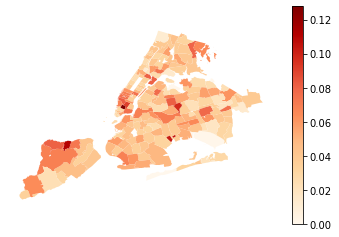

In [109]:
rtl = gdf.merge(rtl_pct.reset_index(), 
                how='left', left_on='region_id', 
                right_on='zipcode')
rtl[rtl[0].notnull()].plot(column=0, cmap='OrRd', legend=True)
plt.axis(False)
_ = plt.box(False)

<br>
<br>

### Analyzing the relationship between land use and income

In [111]:
conn = cenpy.products.APIConnection("ACSDT5Y2018")

In [112]:
names = ['B19013_001E']

In [113]:
data = conn.query(names, geo_unit='zip code tabulation area')

In [117]:
data.rename(columns={'B19013_001E': 'income'}, inplace=True)
data['income'] = data['income'].astype(float)

In [120]:
data = data.replace(-666666666.0, np.nan)

In [123]:
fct_pct = df.groupby('zipcode')['factryarea'].sum() / bld_area

In [127]:
temp = data.merge(fct_pct.reset_index(), 
                  left_on='zip code tabulation area', 
                  right_on='zipcode').dropna()

In [130]:
pearsonr(temp['income'], temp[0])

(-0.1931690659775329, 0.009374203979288875)

TO DO:
- write up